In [1]:
%%sh
#git clone https://github.com/jcboyd/multi-cell-line.git
#ln -s multi-cell-line/src

computing normalization parameters
computing normalization parameters


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


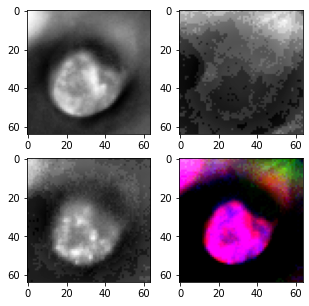

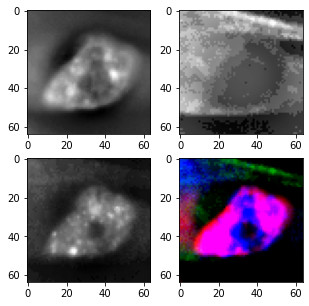

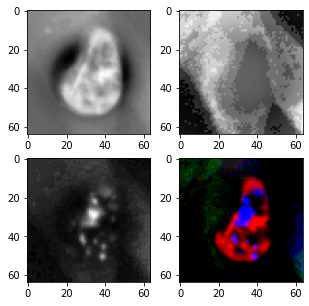

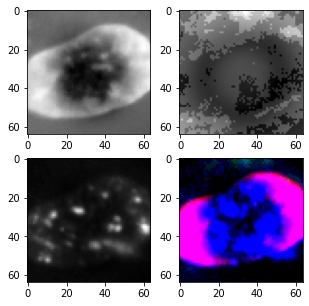

In [2]:
from socket import gethostname

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import torchvision

from datasets import Boyd2019
from losses import ContrastiveLoss
from networks import SiameseNet
from viz import plot_cell, tsne, umap


if gethostname() == 'tael.local':
    from tqdm.notebook import trange, tqdm
else:
    from tqdm import trange, tqdm

data_path = 'data/boyd_2019'
metadata_file = 'data/boyd_2019_PlateMap-KPP_MOA.xlsx'

metadata = Boyd2019.read_metadata(metadata_file)

# filter by 2 moas and make train test
metadata = metadata.loc[metadata.moa.isin(['Neutral', 'EGF Receptor Kinase Inhibitor'])]
train_metadata = metadata.sample(frac = .7)
test_metadata = metadata.drop(train_metadata.index)


boyd2019 = Boyd2019('data/boyd_2019/', train_metadata)

for i in np.random.randint(1, 1000, 4):
    plot_cell(boyd2019.dataset_1[i][0])

# Data generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 1 0 1 0 1 0 1]


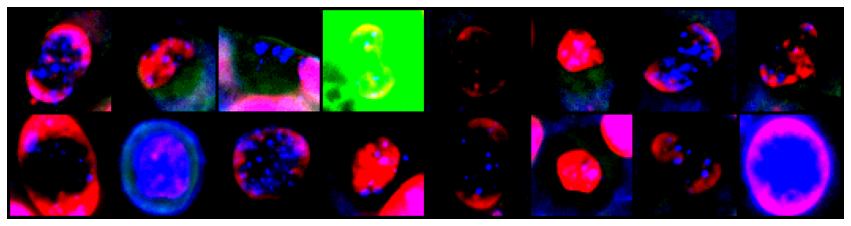

In [3]:
def imshow(img, text=None, should_save=False):

    fig, ax = plt.subplots(figsize=(15, 5))

    npimg = img.numpy()

    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

vis_dataloader = DataLoader(boyd2019,
                            shuffle=True,
                            num_workers=8,
                            batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[2]),0)
print(example_batch[4].numpy())
imshow(torchvision.utils.make_grid(concatenated))

# Training

In [4]:
# training params
train_batch_size = 64
train_number_epochs = 10
train_hosts = ['lion','inu','kuma']
# train_hosts.extend(['tael.local'])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

if (gethostname() in train_hosts):

    train_dataloader = DataLoader(boyd2019,
                                  shuffle=True,
                                  num_workers=8,
                                  batch_size=train_batch_size)

    net = SiameseNet().to(device)
    criterion = ContrastiveLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.0005)
    
    with trange(train_number_epochs) as epochs:
        for epoch in epochs:
            with tqdm(enumerate(train_dataloader,0), total = len(boyd2019)) as tepoch:
                for i, data in tepoch:
                    img0, moa0, img1, moa1, label = data
                    img0, img1, label = img0.to(device), img1.to(device), label.to(device)
                    
                    optimizer.zero_grad()
                    output1,output2 = net(img0,img1)
                    loss = criterion(output1,output2,label)
                    loss.backward()
                    optimizer.step()
                    
                    tepoch.set_postfix(loss=loss.item())

            torch.save(net.state_dict(), 'siamese_%04d.torch' % epoch)

cpu


# Testing

In [5]:
# load saved net
net = SiameseNet().to(device)
net.load_state_dict(torch.load('siamese_0999.torch', map_location=torch.device('cpu')))
net = net.eval()

In [6]:
# get test set: different wells than training
test_metadata = pd.DataFrame({'well': ['C01', 'D02'], 'moa': [1, 2]})
test_boyd2019 = Boyd2019('data/boyd_2019/', test_metadata)

test_dataloader = DataLoader(test_boyd2019,
                             shuffle=True,
                             num_workers=8,
                             batch_size=train_batch_size)

computing normalization parameters
computing normalization parameters


In [7]:
from os.path import join

mda231_path = '22_384_20X-hNA_D_F_C3_C5_20160031_2016.01.25.17.23.13_MDA231'
mda468_path = '22_384_20X-hNA_D_F_C3_C5_20160032_2016.01.25.16.27.22_MDA468'

avg_mda231, std_mda231 = test_boyd2019.load_parameters(join(data_path, mda231_path, 'norm_params.pkl'), None, False)
avg_mda468, std_mda468 = test_boyd2019.load_parameters(join(data_path, mda468_path, 'norm_params.pkl'), None, False)

loading normalization parameters
loading normalization parameters


In [8]:
# sample test set
embedding = np.empty((0, 256))
moas = []
cell_line = np.empty((0,))

all_imgs = []

for i, data in enumerate(test_dataloader, 0):
    img0, moa0, img1, moa1, _ = data
    img0, img1 = img0.to(device), img1.to(device)
    output1, output2 = net(img0, img1)

    embedding = np.concatenate((embedding, output1.detach().numpy(), output2.detach().numpy()))
    cell_line = np.concatenate((cell_line,
                                np.repeat('mda468', output1.shape[0]),
                                np.repeat('mda231', output2.shape[0])))
    moas.extend(moa0)
    moas.extend(moa1)

    # denormalise images
#     all_imgs.append(img0 * std_mda468 + avg_mda468)
#     all_imgs.append(img1 * std_mda231 + avg_mda231)
    all_imgs.append(img0)
    all_imgs.append(img1)

    if i == 100:
        break

all_imgs = torch.cat(all_imgs).cpu()

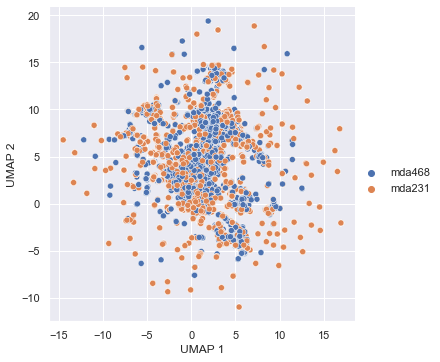

In [9]:
from umap import UMAP
from viz import xy_plot

x_emb = UMAP().fit_transform(embedding)
xy_plot(x_emb, cell_line, 'UMAP')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


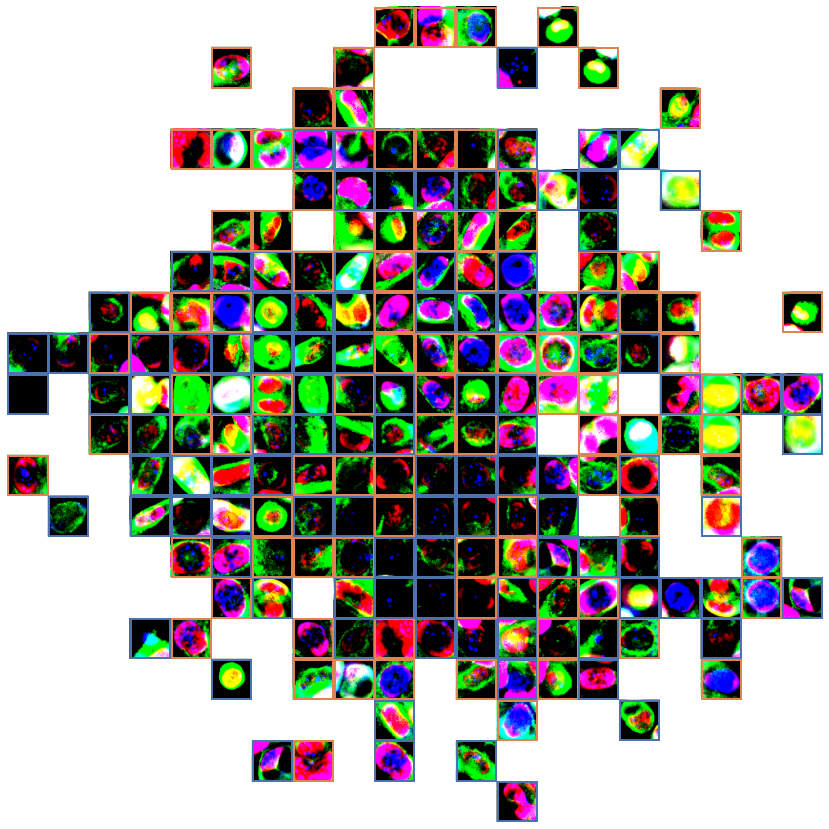

In [10]:
from viz import plot_tiles
import matplotlib.patches as patches

canvas, img_idx_dict = plot_tiles(all_imgs, x_emb, 20, 20)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(canvas)
ax.axis('off')

palette = list(sns.color_palette().as_hex())

for img_key in img_idx_dict.keys():
    xmin, xmax, ymin, ymax = img_idx_dict[img_key]
    cls = moas[img_key].item()
    colour = palette[0] if cls == 1 else palette[1]
    # Create a Rectangle patch
    line_width = 2
    rect = patches.Rectangle((xmin+1, ymin+1), xmax-xmin-2, ymax-ymin-2,
                             linewidth=line_width, edgecolor=colour, facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

In [ ]:
umap(embedding, moas)